In [179]:
%matplotlib inline

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('ggplot')

# Request/Response Time

In [180]:
def load_sim_result(file_name):
    f = open(file_name, 'r')
    # request-response (simulated computation and nw latency)
    # travel time
    # real calculation time for the vehicle
    result_list = {}
    result = []
    plan_per_cycle = []
    rxtx = []
    for r in f:

        line = r.strip().split(' ')
        if line[6].strip() == "ARRIVAL_ESTIMATE_TIME":
            devid = line[8].strip()
            if devid in result_list:
                result_list[devid]["estimate_time_us"] = float(line[7].strip())
            else:
                result_list[devid] = {"estimate_time_us": float(line[7].strip())}
        elif line[6].strip() == "AWAITING_RESPONSE":
            devid = line[8].strip()
            if devid in result_list:
                if not "awaiting_time_s" in result_list[devid]:
                    result_list[devid]["awaiting_time_s"] = float(line[7].strip())
            else:
                result_list[devid] = {"awaiting_time_s": float(line[7].strip())}
        elif line[6].strip() == "V2I_MSG_PROCESSED":
            devid = line[8].strip()
            if devid in result_list:
                result_list[devid]["planning_time_us"] = float(line[7].strip())
            else:
                result_list[devid] = {"planning_time_us": float(line[7].strip())}
        elif line[6].strip() == "RESERVATION_CONFIRMED":
            devid = line[8].strip()
            if devid in result_list:
                result_list[devid]["reserved_time_s"] = float(line[7].strip())
                result_list[devid]["response_time_s"] = result_list[devid]["reserved_time_s"] - result_list[devid]["awaiting_time_s"]
                result_list[devid]["reject_count"] = int(line[9].strip())
                result_list[devid]["unacceptable_count"] = int(line[10].strip())
                result_list[devid]["nw_latency_s"] = float(line[11].strip())                
            else:
                pass
#                result_list[devid] = {"reserved_time": float(line[7].strip())}
            #array_r.append([float(line[0].strip()), int(line[1].strip()), int(line[3].strip()), int(line[4].strip())])
        elif line[6].strip() == "VEHICLE_REMOVED":
            devid = line[8].strip()
            if devid in result_list:
                result_list[devid]["removed_time_s"] = float(line[7].strip())
                result_list[devid]["travel_time_s"] = float(line[9].strip())
            #array_t.append([float(line[0].strip()), int(line[1].strip()), float(line[3].strip())])
        elif line[6].strip() == "V2I_MESSAGE_PROCESSED_PER_STEP":
            plan_per_cycle.append(float(line[7].strip()))
        elif line[6].strip() == "IM_RX_TX_BITS_PER_STEP":
            rxtx.append({
                "timestamp": float(line[7].strip()),
                "rx": int(line[8].strip()),
                "tx": int(line[9].strip()),
                "rx_req": int(line[10].strip())
                        })
        else:
            pass
        
    #df_r = pd.DataFrame(array_r, columns=["time", "vid", "conflicts", "unacceptables"])
    #df_t = pd.DataFrame(array_t, columns=["time", "vid", "duration"])
    for k,v in result_list.items():
        nv = v
        nv["devid"] = k
        result.append(nv)
    return pd.DataFrame(result), pd.Series(plan_per_cycle), pd.DataFrame(rxtx)
    #return (df_r, df_t)

In [181]:
lane1, ppc1, rxtx1 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.04_0.2_201802252320.log")
df1 = lane1.dropna(axis=0, how='any')
lane2, ppc2, rxtx2 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_2l_0.04_0.2_201802252320.log")
df2 = lane2.dropna(axis=0, how='any')
lane3, ppc3, rxtx3 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_3l_0.04_0.2_201802252320.log")
df3 = lane3.dropna(axis=0, how='any')
lane4, ppc4, rxtx4 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_4l_0.04_0.2_201802252320.log")
df4 = lane4.dropna(axis=0, how='any')
lane5, ppc5, rxtx5 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_5l_0.04_0.2_201802252320.log")
df5 = lane5.dropna(axis=0, how='any')

In [182]:
lane6, ppc6, rxtx6 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_6l_0.04_0.2_201802252320.log")
df6 = lane6.dropna(axis=0, how='any')

In [185]:
def gen_span_sum(df):
    span_index = np.arange(0, df["timestamp"].max()+1, 1.0)
    rx_result = pd.Series([df[(df['timestamp'] >= d) & (df['timestamp'] < d+1.0)]['rx'].sum()  for d in span_index])
    tx_result = pd.Series([df[(df['timestamp'] >= d) & (df['timestamp'] < d+1.0)]['tx'].sum()  for d in span_index])
    req_result = pd.Series([df[(df['timestamp'] >= d) & (df['timestamp'] < d+1.0)]['rx_req'].sum()  for d in span_index])
    return pd.concat([pd.Series(span_index),rx_result, tx_result, req_result], axis=1, keys=["timestamp", "rx", "tx", "rx_req"])

In [186]:
rxtx1_sum = gen_span_sum(rxtx1)
rxtx2_sum = gen_span_sum(rxtx2)
rxtx3_sum = gen_span_sum(rxtx3)
rxtx4_sum = gen_span_sum(rxtx4)
rxtx5_sum = gen_span_sum(rxtx5)

In [187]:
rxtx6_sum = gen_span_sum(rxtx6)

In [198]:
lane101, ppc101, rxtx101 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010030.log")
df101 = lane101.dropna(axis=0, how='any')
lane201, ppc201, rxtx201 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_2l_0.1_0.3_201803010030.log")
df201 = lane201.dropna(axis=0, how='any')
lane301, ppc301, rxtx301 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_3l_0.1_0.3_201803010030.log")
df301 = lane301.dropna(axis=0, how='any')
lane401, ppc401, rxtx401 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_4l_0.1_0.3_201803010030.log")
df401 = lane401.dropna(axis=0, how='any')
lane501, ppc501, rxtx501 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_5l_0.1_0.3_201803010030.log")
df501 = lane501.dropna(axis=0, how='any')
lane601, ppc601, rxtx601 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_6l_0.1_0.3_201803010030.log")
df601 = lane601.dropna(axis=0, how='any')

In [199]:
rxtx101_sum = gen_span_sum(rxtx101)
rxtx201_sum = gen_span_sum(rxtx201)
rxtx301_sum = gen_span_sum(rxtx301)
rxtx401_sum = gen_span_sum(rxtx401)
rxtx501_sum = gen_span_sum(rxtx501)
rxtx601_sum = gen_span_sum(rxtx601)

### Planning Time at Intersection Manager

* Lane数が少ない方が時間がかかる傾向。何故か?

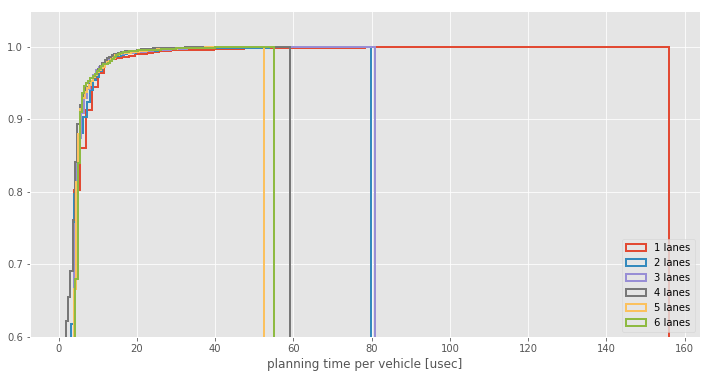

In [189]:
plt.figure(figsize=(12,6))
plt.hist(df1["planning_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df2["planning_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df3["planning_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df4["planning_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df5["planning_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df6["planning_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)

#plt.xlim(0,40)
plt.ylim(0.6, 1.05)
plt.xlabel("planning time per vehicle [usec]")
plt.legend(loc='lower right')

### Estimate time at Vehicles

* lane数が少ないほうが時間がかかる傾向。何故か?

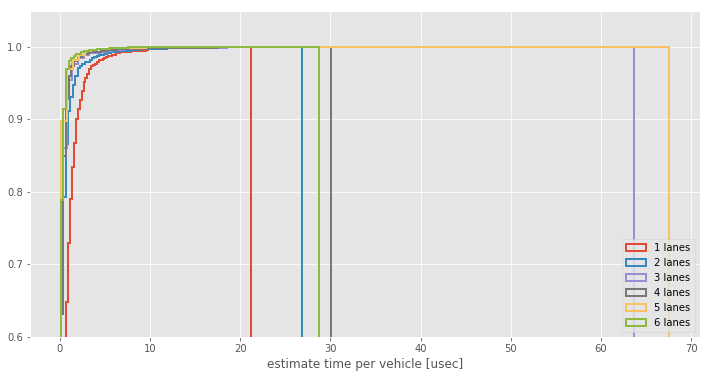

In [190]:
plt.figure(figsize=(12,6))
plt.hist(df1["estimate_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df2["estimate_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df3["estimate_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df4["estimate_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df5["estimate_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df6["estimate_time_us"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)
#plt.xlim(0,40)
plt.ylim(0.6, 1.05)
plt.xlabel("estimate time per vehicle [usec]")
plt.legend(loc='lower right')

In [214]:
df1.describe()

,awaiting_time_s,estimate_time_us,nw_latency_s,planning_time_us,reject_count,removed_time_s,reserved_time_s,response_time_s,travel_time_s,unacceptable_count
count,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.000000,1606.0
mean,1110.264969,1.030563,0.041623,4.803453,16.305729,1127.904421,1111.970286,1.705318,23.988394,0.0
std,624.811296,1.282288,0.017392,5.645182,26.519879,624.711236,624.867054,2.640532,3.827506,0.0
min,0.280000,0.119000,0.020000,0.742000,0.000000,20.960000,0.380000,0.040000,20.860000,0.0
25%,571.785000,0.354250,0.026144,3.059250,0.000000,589.285000,574.075000,0.080000,21.820000,0.0
50%,1137.410000,0.697500,0.040123,3.719000,0.000000,1153.090000,1137.470000,0.100000,23.060000,0.0
75%,1655.020000,1.228750,0.053410,4.734750,27.000000,1672.045000,1656.045000,2.855000,24.800000,0.0
max,2165.780000,21.174000,0.108106,156.065000,223.000000,2180.520000,2167.020000,22.660000,47.240000,0.0


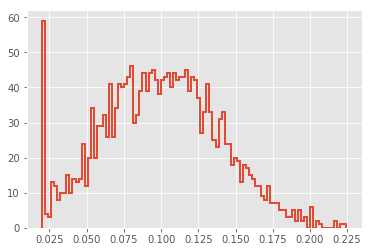

In [219]:
nwlat1 = plt.hist(df101["nw_latency_s"], bins=100, histtype='step', cumulative=False, normed=False, alpha=1, fill=False, label="1 lanes", linewidth=2)


### Reservation Confirmまでの時間

* 必要になってから実際にConfirmedまで至るまでの時間
* median
    * 1l: 0.1s, 2l: 1.1s, 3l: 1.3s, 4l: 1.4s, 5l: 1.7s
* max
    * 1l: 23s, 2l: 28s, 3l: 58s, 4l: 79s, 5l: 168s

/Users/koh1/.pyenv/versions/3.5.4/envs/sandbox/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


(0, 50)

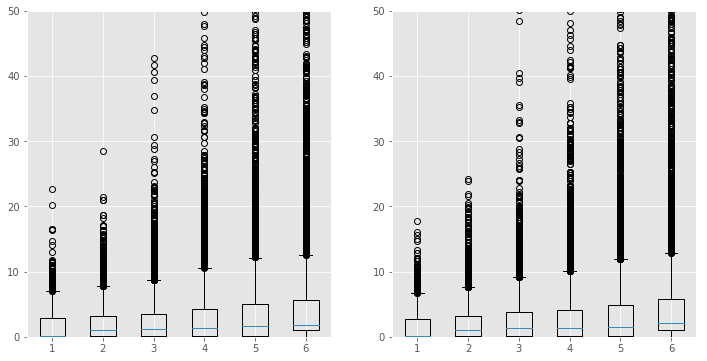

In [203]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
bp = plt.boxplot((df1["response_time_s"], df2["response_time_s"], df3["response_time_s"], df4["response_time_s"], df5["response_time_s"], df6["response_time_s"]))
plt.ylim(0,50)
plt.subplot(1,2,2)
bp01 = plt.boxplot((df101["response_time_s"], df201["response_time_s"], df301["response_time_s"], df401["response_time_s"], df501["response_time_s"], df601["response_time_s"]))
plt.ylim(0,50)

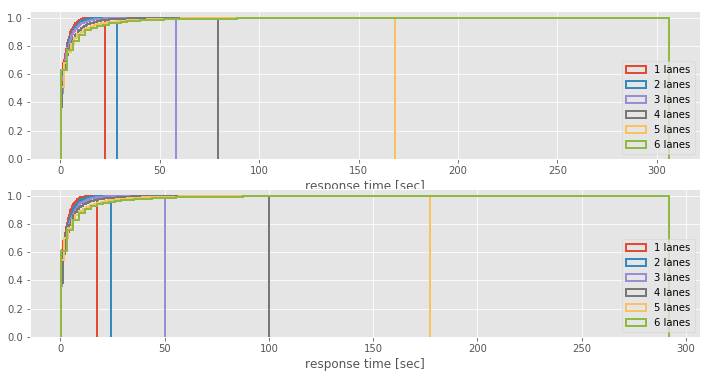

In [204]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.hist(df1["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df2["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df3["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df4["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df5["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df6["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)
#plt.xlim(0,40)
#plt.ylim(0.6, 1.05)
plt.xlabel("response time [sec]")
plt.legend(loc='lower right')
plt.subplot(2,1,2)
plt.hist(df101["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df201["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df301["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df401["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df501["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df601["response_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)
plt.xlabel("response time [sec]")
plt.legend(loc='lower right')

### Confirmedに至るまでのRequest発行回数

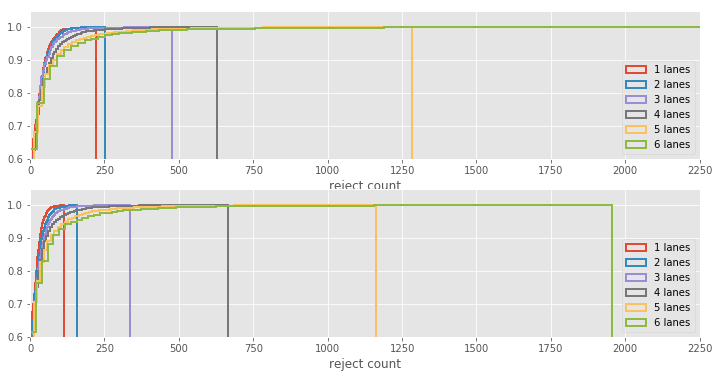

In [207]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.hist(df1["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df2["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df3["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df4["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df5["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df6["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)
plt.xlim(0,2250)
plt.ylim(0.6, 1.05)
plt.xlabel("reject count")
plt.legend(loc='lower right')
plt.subplot(2,1,2)
plt.hist(df101["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df201["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df301["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df401["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df501["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df601["reject_count"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)
plt.xlim(0,2250)
plt.ylim(0.6, 1.05)
plt.xlabel("reject count")
plt.legend(loc='lower right')

### 通過までにかかる時間

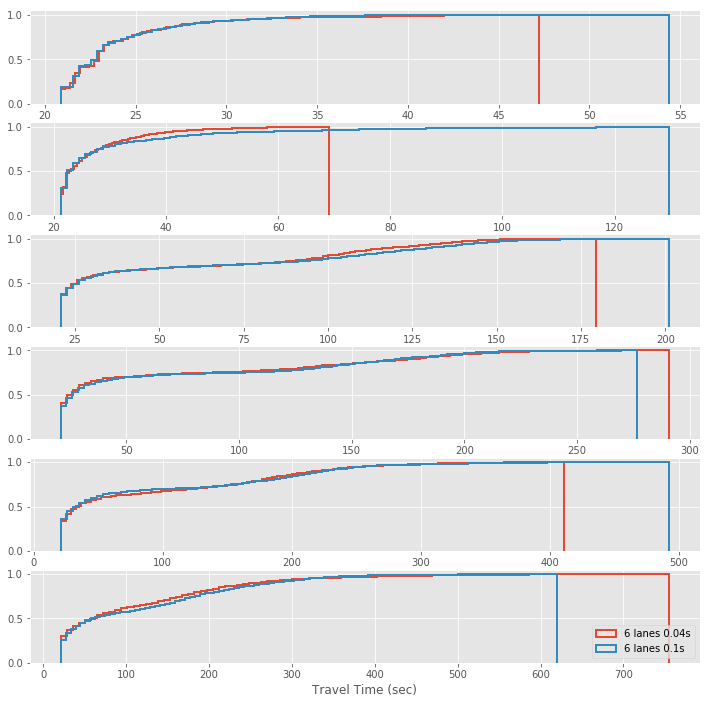

In [213]:
plt.figure(figsize=(12,12))

plt.subplot(6,1,1)
plt.hist(df1["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(df101["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)

plt.subplot(6,1,2)
plt.hist(df2["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(df201["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)

plt.subplot(6,1,3)
plt.hist(df3["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(df301["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)

plt.subplot(6,1,4)
plt.hist(df4["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(df401["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)

plt.subplot(6,1,5)
plt.hist(df5["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(df501["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)

plt.subplot(6,1,6)
plt.hist(df6["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes 0.04s", linewidth=2)
plt.hist(df601["travel_time_s"], bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes 0.1s", linewidth=2)
#plt.xlim(0,800)
#plt.ylim(0.6, 1.05)
plt.xlabel("Travel Time (sec)")
plt.legend(loc='lower right')

### IM 1cycleでの演算時間

* 実際には処理しきれていないにも関わらず、Simulation上は処理しきれたことになっている
    * 1 cycle = 20msに対して、いずれの結果もCDFが1に達していない

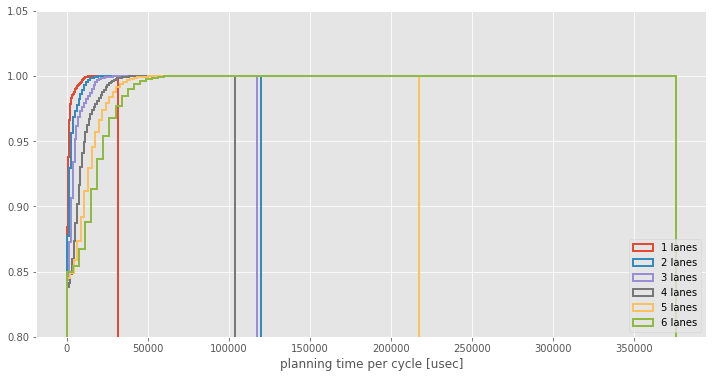

In [210]:
plt.figure(figsize=(12,6))
plt.hist(ppc1, bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="1 lanes", linewidth=2)
plt.hist(ppc2, bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="2 lanes", linewidth=2)
plt.hist(ppc3, bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="3 lanes", linewidth=2)
plt.hist(ppc4, bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="4 lanes", linewidth=2)
plt.hist(ppc5, bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="5 lanes", linewidth=2)
plt.hist(ppc6, bins=100, histtype='step', cumulative=True, normed=True, alpha=1, fill=False, label="6 lanes", linewidth=2)
#plt.xlim(0,20000)
plt.ylim(0.8, 1.05)
plt.xlabel("planning time per cycle [usec]")
plt.legend(loc='lower right')

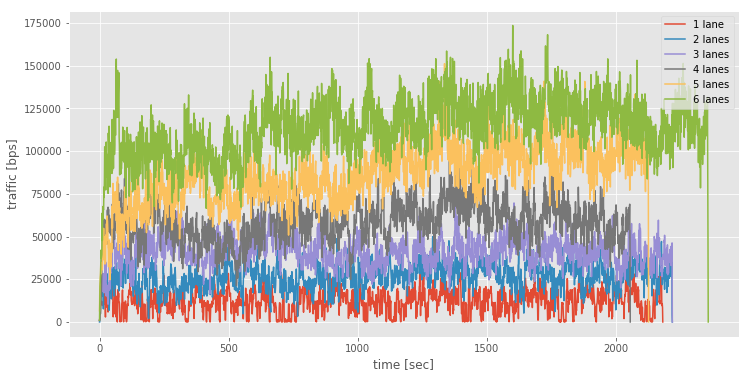

In [211]:
plt.figure(figsize=(12,6))
plt.plot(rxtx1_sum["rx"], label="1 lane")
plt.plot(rxtx2_sum["rx"], label="2 lanes")
plt.plot(rxtx3_sum["rx"], label="3 lanes")
plt.plot(rxtx4_sum["rx"], label="4 lanes")
plt.plot(rxtx5_sum["rx"], label="5 lanes")
plt.plot(rxtx6_sum["rx"], label="6 lanes")
#plt.xlim(0,20000)
#plt.ylim(0.8, 1.05)
plt.xlabel("time [sec]")
plt.ylabel("traffic [bps]")
plt.legend(loc='upper right')

In [ ]:
rxtx4_sum["rx_req"].describe()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(rxtx1_sum["tx"], '-', label="1 lane")
plt.plot(rxtx2_sum["tx"], '-', label="2 lanes")
plt.plot(rxtx3_sum["tx"], '-', label="3 lanes")
plt.plot(rxtx4_sum["tx"], '-', label="4 lanes")
plt.plot(rxtx5_sum["tx"], '-', label="5 lanes")
plt.plot(rxtx6_sum["tx"], '-', label="6 lanes")
plt.xlabel("time [sec]")
plt.ylabel("traffic [bps]")
plt.legend(loc='upper right')

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(rxtx1_sum["rx_req"], '-', label="1 lane")
plt.plot(rxtx2_sum["rx_req"], '-', label="2 lanes")
plt.plot(rxtx3_sum["rx_req"], '-', label="3 lanes")
plt.plot(rxtx4_sum["rx_req"], '-', label="4 lanes")
plt.plot(rxtx5_sum["rx_req"], '-', label="5 lanes")
plt.plot(rxtx6_sum["rx_req"], '-', label="6 lanes")
plt.xlabel("time [sec]")
plt.ylabel("requests [rps]")
plt.legend(loc='upper right')

In [ ]:
lane101, ppc101, rxtx101 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010003.log")
df101 = lane101.dropna(axis=0, how='any')
lane201, ppc201, rxtx201 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010003.log")
df201 = lane201.dropna(axis=0, how='any')
lane301, ppc301, rxtx301 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010003.log")
df301 = lane301.dropna(axis=0, how='any')
lane401, ppc401, rxtx401 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010003.log")
df401 = lane401.dropna(axis=0, how='any')
lane501, ppc501, rxtx501 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010003.log")
df501 = lane501.dropna(axis=0, how='any')
lane601, ppc601, rxtx601 = load_sim_result("/Users/koh1/dev/aim4-dev/logs/v1000_1l_0.1_0.3_201803010003.log")
df601 = lane601.dropna(axis=0, how='any')